FRAUD DETECTION

IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import torch  #open-source machine learning framework
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import numpy as np # linear algebra

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

LOADING DATASETS

In [ ]:
df=pd.read_csv('Transaction_details.csv')
df

In [ ]:
pd.set_option('display.max_columns', 11)

pd.set_option('display.max_rows', 65535)

WORKING DATASET

In [ ]:
df0 = pd.concat([df['TD_DTRAN_AMOUNT'], df['TD_STRAN_CURRENCY'], df['TD_DTRAN_DATE_TIME'], df['TD_SINSTITUTION_ID'],
                 df['TD_SMERCHANT_ID'], df['TD_STERMINAL_ID'], df['TD_SRESULT'], df['TD_SCARDHOLDER_NAME'],
                 df['TD_SMASKEDCARDNUMBER'], df['TD_SCUST_IP'], df['TD_SFRAUD_1_STATUS']], axis=1)

In [ ]:
df0.shape

(65534, 11)

In [ ]:
df0.nunique()

TD_DTRAN_AMOUNT           546
TD_STRAN_CURRENCY          13
TD_DTRAN_DATE_TIME      29211
TD_SINSTITUTION_ID         34
TD_SMERCHANT_ID           121
TD_STERMINAL_ID           206
TD_SRESULT                 11
TD_SCARDHOLDER_NAME      1141
TD_SMASKEDCARDNUMBER      193
TD_SCUST_IP               373
TD_SFRAUD_1_STATUS          2
dtype: int64

In [ ]:
df0.describe()

TD_DTRAN_AMOUNT  TD_SFRAUD_1_STATUS
count     6.553400e+04        65534.000000
mean      3.463916e+05            0.004563
std       1.891333e+07            0.067393
min       0.000000e+00            0.000000
25%       2.000000e+00            0.000000
50%       1.000000e+01            0.000000
75%       2.000000e+01            0.000000
max       1.321321e+09            1.000000

In [ ]:
null_counts = df0.isnull().sum()
null_counts

TD_DTRAN_AMOUNT             0
TD_STRAN_CURRENCY           3
TD_DTRAN_DATE_TIME          0
TD_SINSTITUTION_ID         87
TD_SMERCHANT_ID            87
TD_STERMINAL_ID             0
TD_SRESULT                  6
TD_SCARDHOLDER_NAME      7759
TD_SMASKEDCARDNUMBER    13510
TD_SCUST_IP              4211
TD_SFRAUD_1_STATUS          0
dtype: int64

In [ ]:
columns_to_drop = null_counts[null_counts > 65532].index
columns_to_drop

df0 = df0.drop(columns_to_drop, axis=1)

In [ ]:
for column in df0.columns:
    # Check the data type of the column
    column_dtype = df0[column].dtype

    # Fill missing values based on the data type
    if column_dtype == 'object':
        df0[column] = df0[column].fillna('Unknown')
    elif column_dtype == 'float64':
        df0[column] = df0[column].fillna('NaN')
    elif column_dtype == 'int64':
        df0[column] = df0[column].fillna('NaN')


# Verify if all missing values are filled
print(df0.isnull().sum())

TD_DTRAN_AMOUNT         0
TD_STRAN_CURRENCY       0
TD_DTRAN_DATE_TIME      0
TD_SINSTITUTION_ID      0
TD_SMERCHANT_ID         0
TD_STERMINAL_ID         0
TD_SRESULT              0
TD_SCARDHOLDER_NAME     0
TD_SMASKEDCARDNUMBER    0
TD_SCUST_IP             0
TD_SFRAUD_1_STATUS      0
dtype: int64


In [ ]:
df0.dtypes

TD_DTRAN_AMOUNT         float64
TD_STRAN_CURRENCY        object
TD_DTRAN_DATE_TIME       object
TD_SINSTITUTION_ID       object
TD_SMERCHANT_ID          object
TD_STERMINAL_ID          object
TD_SRESULT               object
TD_SCARDHOLDER_NAME      object
TD_SMASKEDCARDNUMBER     object
TD_SCUST_IP              object
TD_SFRAUD_1_STATUS        int64
dtype: object

In [ ]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

object_columns = df0.select_dtypes(include='object').columns

label_encoder = LabelEncoder()

for column in object_columns:
    df0[column] = df0[column].astype(str)
    df0[column] = label_encoder.fit_transform(df0[column])

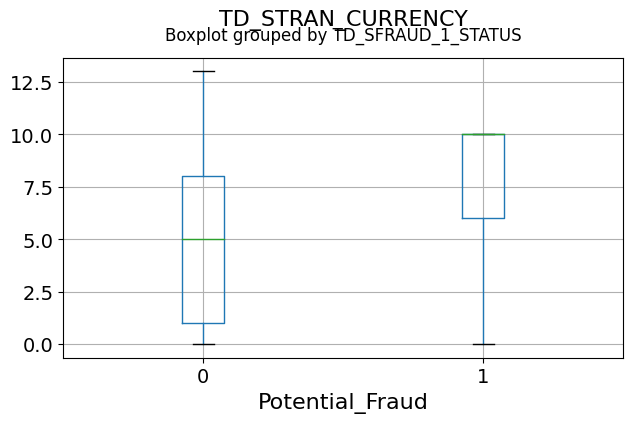

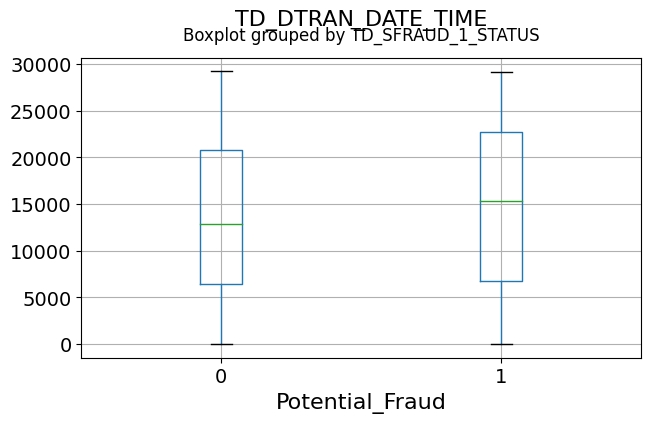

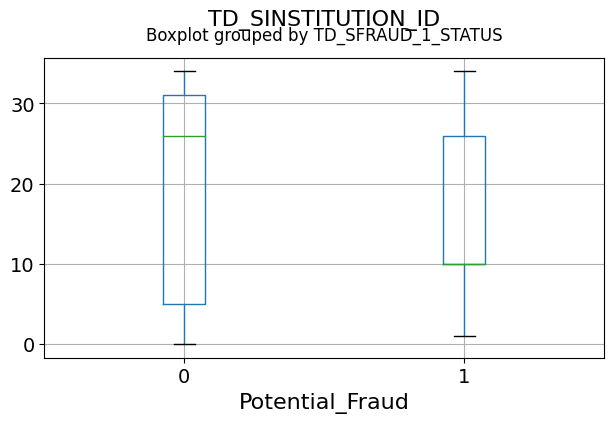

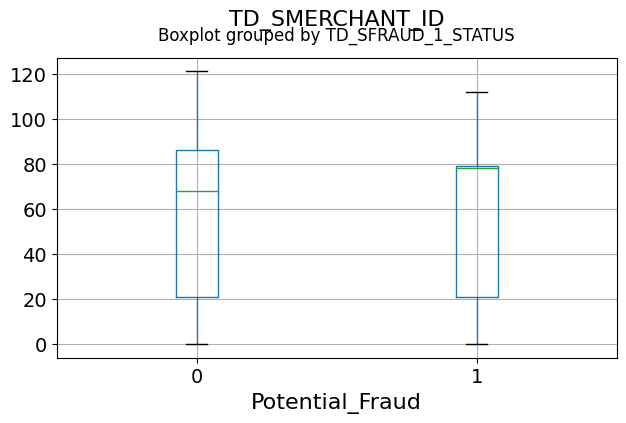

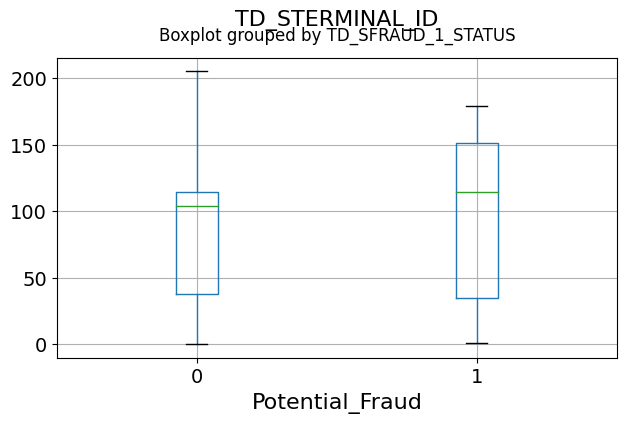

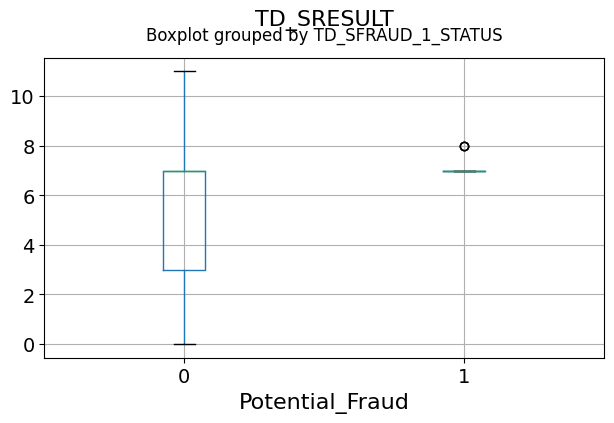

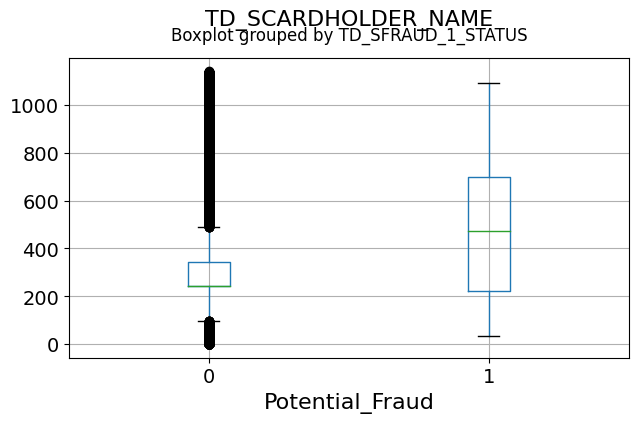

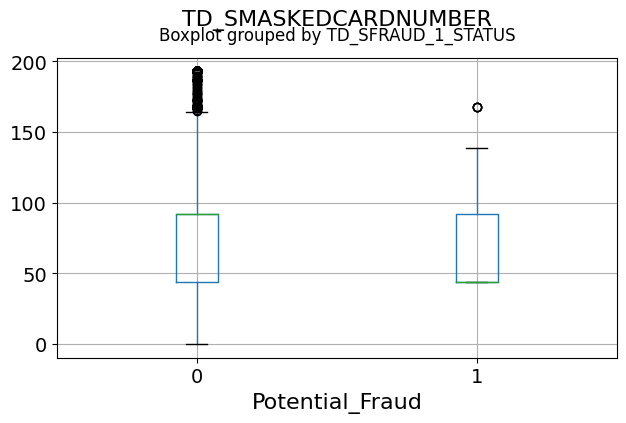

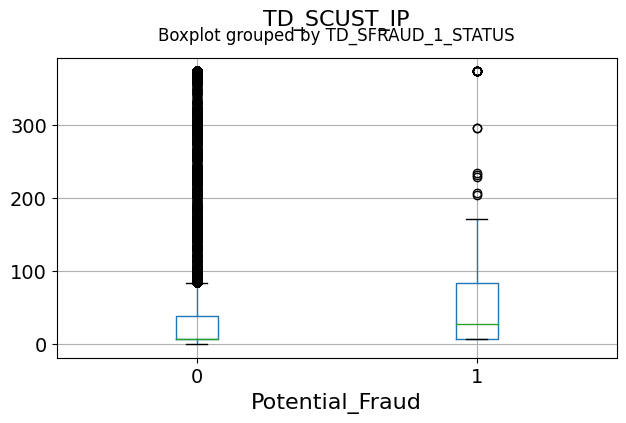

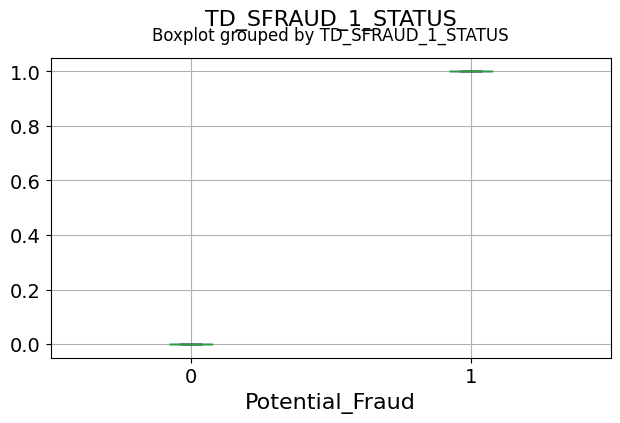

In [ ]:
for c in df0.columns[1:]:
    df0.boxplot(c, by='TD_SFRAUD_1_STATUS', figsize=(7,4), fontsize=14)
    plt.title("{}\n".format(c), fontsize=16)
    plt.xlabel("Potential_Fraud", fontsize=16)

<ipython-input-14-c1619014bcbb>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 30)
<ipython-input-14-c1619014bcbb>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
<ipython-input-14-c1619014bcbb>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels, fontsize=12)
<ipython-input-14-c1619014bcbb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels, fontsize=12)


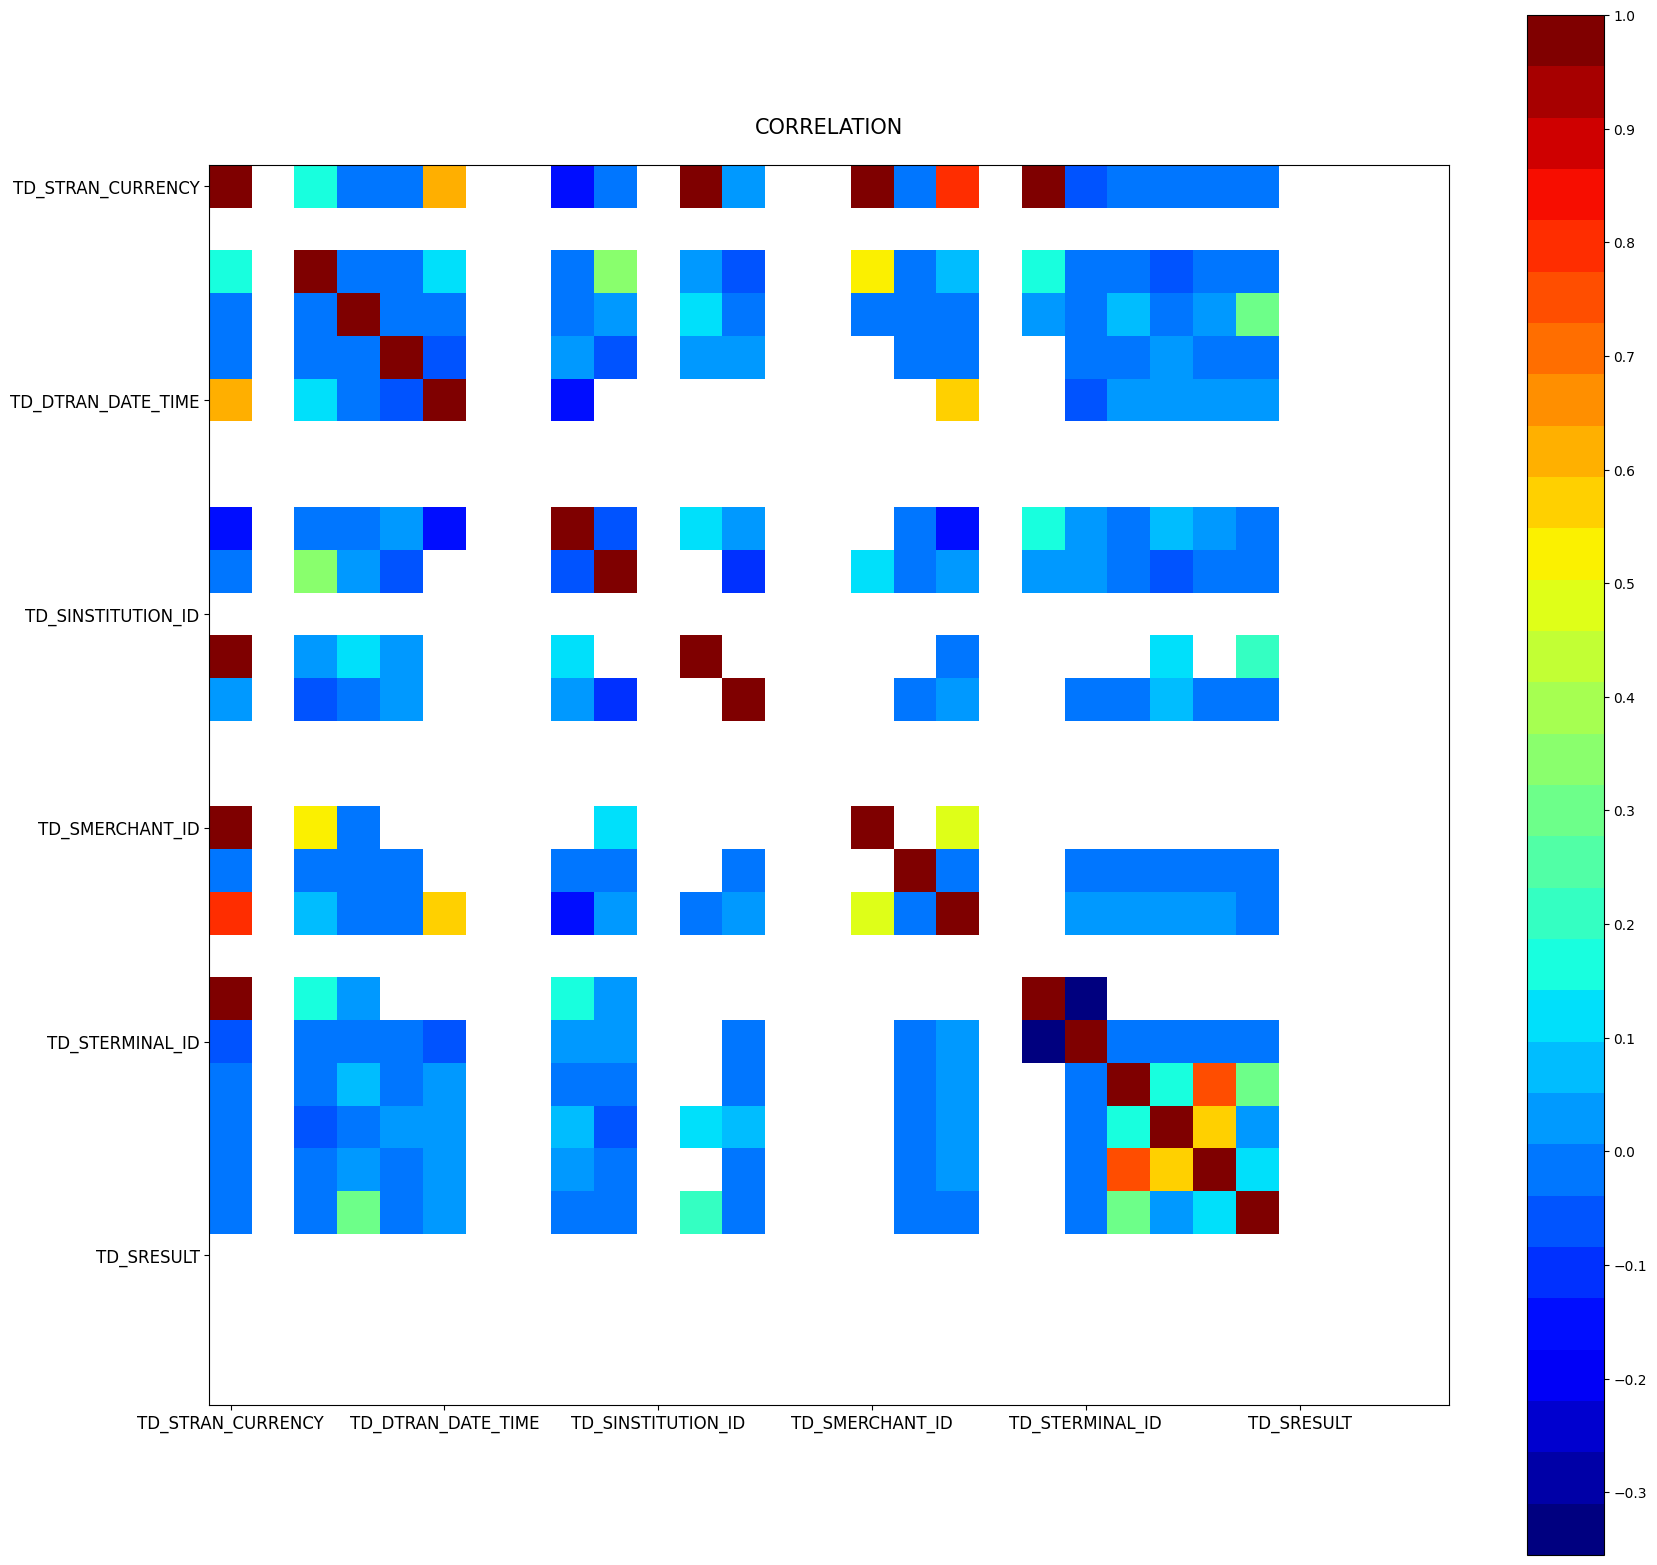

In [ ]:
def correlation_matrix(df0):
  from matplotlib import pyplot as plt
  from matplotlib import cm as cm

  fig = plt.figure(figsize=(20,20))
  ax1 = fig.add_subplot(111)
  cmap = cm.get_cmap('jet', 30)
  cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
  plt.title('CORRELATION\n', fontsize=15)
  labels = df0.columns
  ax1.set_xticklabels(labels, fontsize=12)
  ax1.set_yticklabels(labels, fontsize=12)
  #adding colorbar
  fig.colorbar(cax, ticks=[0.1*i for i in range(-11,11)])
  plt.show()

correlation_matrix(df0)

TRAINING MODEL

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df0.drop('TD_SFRAUD_1_STATUS', axis=1)
y = df0['TD_SFRAUD_1_STATUS']
X = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

***SVC***

In [ ]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
df1 = pd.DataFrame({'Predicted values' : y_pred, 'Actual_values': y_test})
df1

Predicted values  Actual_values
13378                 0              0
17928                 0              0
5340                  0              0
36583                 0              0
57850                 0              0
22455                 0              0
51068                 0              0
51594                 0              0
41416                 0              0
31806                 0              0
5110                  0              0
42374                 0              0
23984                 0              0
55570                 0              0
47930                 0              0
54252                 0              0
33579                 0              0
32225                 0              0
17061                 0              0
52059                 0              0
47100                 0              0
39088                 0              0
59263                 0              0
29677                 0              0
203                   0              0
32233                 0              0
21191                 0              0
29526                 0              0
49821                 0              0
51506                 0              0
62362                 0              0
33730                 0              0
57811                 0              0
64711                 0              0
5483                  0              0
62186                 0              0
49450                 0              0
20089                 0              0
6590                  0              0
25369                 0              0
60195                 0              0
31332                 0              0
16408                 0              0
470                   0              0
48252                 0              0
6620                  0              0
35470                 0              0
24826                 0              0
49879                 0              0
53185                 0              0
1225                  0              0
34871                 0              0
18142                 0              0
13441                 0              0
11307                 0              0
7072                  0              0
49122                 0              0
47308                 0              0
2568                  0              0
32533                 0              0
25935                 0              0
52328                 0              0
17296                 0              0
36106                 0              0
14047                 0              0
51402                 0              0
10459                 0              0
30982                 0              0
39305                 0              0
17784                 0              0
23251                 0              0
21031                 0              0
26748                 0              0
18067                 0              0
22969                 0              1
11344                 0              0
38677                 0              0
57717                 0              0
24633                 0              0
1686                  0              0
26339                 0              0
22539                 0              0
20663                 0              0
2107                  0              0
19124                 0              0
34923                 0              0
64033                 0              0
29377                 0              0
29316                 0              0
48400                 0              0
7891                  0              0
30751                 0              0
18223                 0              0
3607                  0              0
64921                 0              0
53720                 0              0
43054                 0              0
14581                 0              0
16141                 0              0
28519                 0              0
35818                 0              0
44186                 0      

In [ ]:
#building all kinds of evaluating parameters
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

n_errors = (y_pred != y_test).sum()
print("The model used is Support Vector classifier")

acc = accuracy_score(y_test, y_pred)
print("The accuracy is {}".format(acc))

prec = precision_score(y_test, y_pred,average='weighted', labels=np.unique(y_pred))
print("The precision is {}".format(prec))

rec = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print("The recall is {}".format(rec))

f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
print("The F1-Score is {}".format(f1))

The model used is Support Vector classifier
The accuracy is 0.9962870657647118
The precision is 0.9962870657647119
The recall is 1.0
The F1-Score is 0.9981400800020381


***RANDOM FOREST CLASSIFIER***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RCLF = RandomForestClassifier(n_estimators = 100, random_state = 55)
RCLF.fit(x_train,y_train)

RandomForestClassifier(random_state=55)

In [ ]:
y1_pred=RCLF.predict(x_test)
df2 = pd.DataFrame({'Predicted values' : y1_pred, 'Actual_values': y_test})
df2

In [ ]:
#building all kinds of evaluating parameters

n1_errors = (y1_pred != y_test).sum()
print("The model used is Random Forest classifier")

acc1 = accuracy_score(y_test, y1_pred)
print("The accuracy is {}".format(acc1))

prec1 = precision_score(y_test, y1_pred,average='weighted', labels=np.unique(y1_pred))
print("The precision is {}".format(prec1))

rec1 = recall_score(y_test, y1_pred, average='weighted', labels=np.unique(y1_pred))
print("The recall is {}".format(rec1))

f1_1 = f1_score(y_test, y1_pred, average='weighted', labels=np.unique(y1_pred))
print("The F1-Score is {}".format(f1_1))

The model used is Random Forest classifier
The accuracy is 0.9946086160419104
The precision is 0.9939686794573337
The recall is 0.9946086160419104
The F1-Score is 0.9942779390746003


PYCARET

In [ ]:
!pip install pycaret

In [ ]:
import pycaret
from pycaret.datasets import get_data

In [ ]:
from pycaret.classification import *
exp = setup(data=df0, target='TD_SFRAUD_1_STATUS',train_size=0.70, session_id=123)

In [ ]:
best_model = compare_models(fold=4)

Processing:   0%|          | 0/65 [00:00<?, ?it/s]